In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from scipy.stats import randint, uniform
import joblib

In [2]:
# Standard color palette for visualizations
COLORS = {
    'light_main': '#4CAF50',       # Light green (ej. éxito, bajo riesgo)
    'dark_main': '#2E7D32',      # Dark green (ej. alto rendimiento)
    'light_secundary': '#FFC107',      # Yellow (ej. riesgo moderado, atención)
    'dark_secundary': '#FFA000',     # Orange (ej. riesgo alto, alerta)
    'blue_complementary': '#2196F3',   # Blue (ej. variables de información)
    'gray_complementary': '#B0BEC5',   # Light gray (ej. fondo, texto secundario)
    'black_complementary': '#424242'   # Black (ej. texto principal, títulos)
}

# Global aesthetic settings for matplotlib and seaborn
plt.style.use('ggplot')
# sns.set_palette([COLORS['dark_main'], COLORS['dark_secundary'], COLORS['blue_complementary'], COLORS['light_main']])


In [3]:
# Load dataset
try:
    df = pd.read_csv('student_habits_performance.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: The file 'student_habits_performance.csv' was not found. Make sure it's in the correct directory.")
    exit()

Dataset loaded successfully.


In [4]:
# Vista general
print(df.shape)
print(df.info())

(1000, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   student_id                     1000 non-null   object 
 1   age                            1000 non-null   int64  
 2   gender                         1000 non-null   object 
 3   study_hours_per_day            1000 non-null   float64
 4   social_media_hours             1000 non-null   float64
 5   netflix_hours                  1000 non-null   float64
 6   part_time_job                  1000 non-null   object 
 7   attendance_percentage          1000 non-null   float64
 8   sleep_hours                    1000 non-null   float64
 9   diet_quality                   1000 non-null   object 
 10  exercise_frequency             1000 non-null   int64  
 11  parental_education_level       909 non-null    object 
 12  internet_quality               1000 no

In [5]:
df.head()

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,S1000,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,S1001,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,S1002,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3
3,S1003,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Master,Good,1,Yes,26.8
4,S1004,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Master,Good,1,No,66.4


In [6]:
#Check for null values
df.isnull().sum()
print("\nValores nulos:")
print(df.isnull().sum())


Valores nulos:
student_id                        0
age                               0
gender                            0
study_hours_per_day               0
social_media_hours                0
netflix_hours                     0
part_time_job                     0
attendance_percentage             0
sleep_hours                       0
diet_quality                      0
exercise_frequency                0
parental_education_level         91
internet_quality                  0
mental_health_rating              0
extracurricular_participation     0
exam_score                        0
dtype: int64


In [7]:
print(df['parental_education_level'].unique())

['Master' 'High School' 'Bachelor' nan]


In [8]:
# Impute categorical variables with 'Unknown'
df['parental_education_level'] = df['parental_education_level'].fillna('Unknown')

In [9]:
# Filter all duplicate records (including the first occurrence)
all_duplicates = df[df.duplicated(keep=False)]
print("\nAll duplicate records:\n", all_duplicates)


All duplicate records:
 Empty DataFrame
Columns: [student_id, age, gender, study_hours_per_day, social_media_hours, netflix_hours, part_time_job, attendance_percentage, sleep_hours, diet_quality, exercise_frequency, parental_education_level, internet_quality, mental_health_rating, extracurricular_participation, exam_score]
Index: []


In [10]:
unique_counts = df.select_dtypes(include='object').nunique().to_frame('Valores Únicos')
print("Number of unique values ​​per column (object):")
print(unique_counts)

Number of unique values ​​per column (object):
                               Valores Únicos
student_id                               1000
gender                                      3
part_time_job                               2
diet_quality                                3
parental_education_level                    4
internet_quality                            3
extracurricular_participation               2


In [11]:
columns = [col for col in df.columns if df[col].dtype == 'object' and col != 'student_id']
for col in columns:
    print(col + ":")
    print(df[col].unique())
    print()

gender:
['Female' 'Male' 'Other']

part_time_job:
['No' 'Yes']

diet_quality:
['Fair' 'Good' 'Poor']

parental_education_level:
['Master' 'High School' 'Bachelor' 'Unknown']

internet_quality:
['Average' 'Poor' 'Good']

extracurricular_participation:
['Yes' 'No']



In [12]:
# Standardize values
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

In [13]:
# Convert categorical columns to category data type
df = df.astype({
    col: 'category'
    for col in df.select_dtypes(include='object').columns
    if col != 'student_id'
})

In [14]:
#check for incorrect numerical values
#Negative or extremely high values
df.describe()

,age,study_hours_per_day,social_media_hours,netflix_hours,attendance_percentage,sleep_hours,exercise_frequency,mental_health_rating,exam_score
count,1000.0000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.4980,3.55010,2.505500,1.819700,84.131700,6.470100,3.042000,5.438000,69.601500
std,2.3081,1.46889,1.172422,1.075118,9.399246,1.226377,2.025423,2.847501,16.888564
min,17.0000,0.00000,0.000000,0.000000,56.000000,3.200000,0.000000,1.000000,18.400000
25%,18.7500,2.60000,1.700000,1.000000,78.000000,5.600000,1.000000,3.000000,58.475000
50%,20.0000,3.50000,2.500000,1.800000,84.400000,6.500000,3.000000,5.000000,70.500000
75%,23.0000,4.50000,3.300000,2.525000,91.025000,7.300000,5.000000,8.000000,81.325000
max,24.0000,8.30000,7.200000,5.400000,100.000000,10.000000,6.000000,10.000000,100.000000


In [15]:
# Save the cleaned dataset
df.to_csv('student_habits_performance_clean.csv', index=False)

## Feature Engineering


Distribution of 'exam_score':


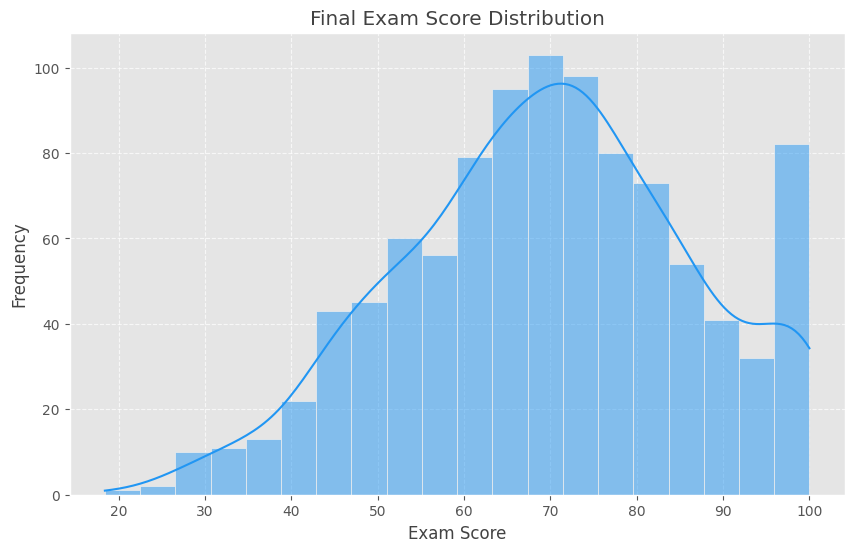

Average exam score: 69.60
Median exam score: 70.50
Standard deviation of the test score: 16.89


In [16]:
# Analysis of the target variable 'exam_score'
print("\nDistribution of 'exam_score':")
plt.figure(figsize=(10, 6))
sns.histplot(df['exam_score'], bins=20, kde=True, color=COLORS['blue_complementary'])
plt.title('Final Exam Score Distribution', color=COLORS['black_complementary'])
plt.xlabel('Exam Score', color=COLORS['black_complementary'])
plt.ylabel('Frequency', color=COLORS['black_complementary'])
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

print(f"Average exam score: {df['exam_score'].mean():.2f}")
print(f"Median exam score: {df['exam_score'].median():.2f}")
print(f"Standard deviation of the test score: {df['exam_score'].std():.2f}")


Low performance threshold defined: < 70 puntos.

Distribution of the new target variable 'low_performance':
low_performance
0    511
1    489
Name: count, dtype: int64
Percentage of students at risk (low_performance=1): 48.90%


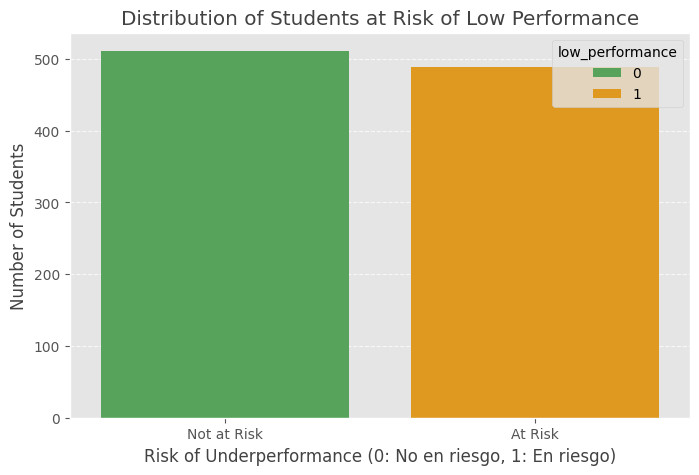

In [17]:
# Create the binary target variable 'low performance'
# Low performance threshold at a fixed score < 70, according to experts.
low_performance_threshold = 70
df['low_performance'] = (df['exam_score'] < low_performance_threshold).astype(int)

print(f"\nLow performance threshold defined: < {low_performance_threshold} puntos.")
print("\nDistribution of the new target variable 'low_performance':")
print(df['low_performance'].value_counts())
print(f"Percentage of students at risk (low_performance=1): {df['low_performance'].mean() * 100:.2f}%")

plt.figure(figsize=(8, 5))
sns.countplot(x='low_performance', data=df, hue='low_performance', palette=[COLORS['light_main'], COLORS['dark_secundary']])
plt.title('Distribution of Students at Risk of Low Performance', color=COLORS['black_complementary'])
plt.xlabel('Risk of Underperformance (0: No en riesgo, 1: En riesgo)', color=COLORS['black_complementary'])
plt.ylabel('Number of Students', color=COLORS['black_complementary'])
plt.xticks([0, 1], ['Not at Risk', 'At Risk'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## Preparation for modeling

In [18]:
# The following variables will be our features:
features = [col for col in df.columns if col not in ['student_id', 'exam_score', 'low_performance']]
print(f"\nVariables selected for the model: {features}")


Variables selected for the model: ['age', 'gender', 'study_hours_per_day', 'social_media_hours', 'netflix_hours', 'part_time_job', 'attendance_percentage', 'sleep_hours', 'diet_quality', 'exercise_frequency', 'parental_education_level', 'internet_quality', 'mental_health_rating', 'extracurricular_participation']


In [19]:
print("\n--- Data Preprocessing ---")

# Separate features (X) and target variable (y)
X = df[features]
y = df['low_performance']

print(f"Dimensions of X: {X.shape}")
print(f"Dimensions of y: {y.shape}")


--- Data Preprocessing ---
Dimensions of X: (1000, 14)
Dimensions of y: (1000,)


In [20]:
# Identify numerical and categorical variables.
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()

# Categorical variables that are nominal and require OneHotEncoding.
# I included 'gender' (to handle 'Other') and 'parental_education_level' (to handle 'Unknown').
onehot_cols = ['gender', 'parental_education_level', 'part_time_job', 'extracurricular_participation']

# Categorical variables that are ordinal and require OrdinalEncoder.
ordinal_cols = ['diet_quality', 'internet_quality']

In [21]:
diet_quality_map = ['Poor', 'Fair', 'Good']
internet_quality_map = ['Poor', 'Average', 'Good']

# Create preprocessing pipelines.
# 1. Pipeline for numerical variables (scaling).
numerical_transformer = StandardScaler()

# 2. Pipeline for nominal categorical variables (One-Hot Encoding).
# 'handle_unknown='ignore'' prevents errors if new categories appear in the test set.
onehot_transformer = OneHotEncoder(handle_unknown='ignore')

# 3. Pipeline for ordinal categorical variables (Ordinal Encoding).
# 'handle_unknown='use_encoded_value', unknown_value=-1' assigns -1 to unknown categories.
ordinal_transformer = OrdinalEncoder(categories=[diet_quality_map, internet_quality_map],
                                     handle_unknown='use_encoded_value', unknown_value=-1)

# Combine transformers using ColumnTransformer.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('onehot', onehot_transformer, onehot_cols),
        ('ordinal', ordinal_transformer, ordinal_cols)
    ],
    remainder='passthrough' 
)

In [22]:
# Split the data into training and test sets.
# 'Stratify=y' is used to maintain the proportion of the target class in both sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"\nDimensions of X_train: {X_train.shape}")
print(f"Dimensions of X_test: {X_test.shape}")
print(f"Dimensions of y_train: {y_train.shape}")
print(f"Dimensions of y_test: {y_test.shape}")

print("\nConfigured data preprocessing and split data.")


Dimensions of X_train: (750, 14)
Dimensions of X_test: (250, 14)
Dimensions of y_train: (750,)
Dimensions of y_test: (250,)

Configured data preprocessing and split data.


## Predictive Modeling

In [23]:
# --- Modeling & Training)---
print("\n--- Modeling & Training ---")

# Define the pipeline with SMOTE and the classifier.
# I've used ImbPipeline to properly integrate SMOTE into the cross-validation flow.
model_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)), # SMOTE applied only to the training set of each fold.
    ('classifier', RandomForestClassifier(random_state=42))
])


--- Modeling & Training ---


In [24]:
# Define the hyperparameter search space for RandomizedSearchCV.
param_distributions = {
    'classifier__n_estimators': randint(100, 500), # Number of trees in the forest.
    'classifier__max_features': ['sqrt', 'log2', None], # Number of features to consider for the best split.
    'classifier__max_depth': randint(10, 30), # Maximum depth of the tree.
    'classifier__min_samples_split': randint(2, 10), # Minimum number of samples required to split a node.
    'classifier__min_samples_leaf': randint(1, 4), # Minimum number of samples required at the leaf node.
    'classifier__class_weight': [None, 'balanced'] # Weight classes to manage imbalance.
}


In [25]:
# Configure RandomizedSearchCV with stratified cross-validation.
# StratifiedKFold ensures that each cross-validation fold has the same proportion of classes.
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=param_distributions,
    n_iter=50, # Number of hyperparameter combinations to test. Increase for more exhaustive searches.
    cv=cv_strategy,
    scoring='roc_auc', # I've used AUC-ROC as the primary metric for model selection.
    verbose=2,
    n_jobs=-1, # Use all available CPU cores.
    random_state=42
)

print("\nStarting hyperparameter search and model training (this may take a while)...")
random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_
print(f"\nBest model found: {random_search.best_params_}")
print(f"Best score (AUC-ROC) in cross-validation: {random_search.best_score_:.4f}")

print("\nFinal trained and optimized model.")


Starting hyperparameter search and model training (this may take a while)...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best model found: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 16, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 476}
Best score (AUC-ROC) in cross-validation: 0.9483

Final trained and optimized model.


In [26]:
# --- Model Evaluation ---
print("\n--- Model Evaluation ---")

y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1] # Probabilities for the positive class (risk).

print("\nClassification Report on the test set:")
print(classification_report(y_test, y_pred, target_names=['Not at Risk', 'At Risk']))



--- Model Evaluation ---

Classification Report on the test set:
              precision    recall  f1-score   support

 Not at Risk       0.89      0.86      0.87       128
     At Risk       0.86      0.89      0.87       122

    accuracy                           0.87       250
   macro avg       0.87      0.87      0.87       250
weighted avg       0.87      0.87      0.87       250



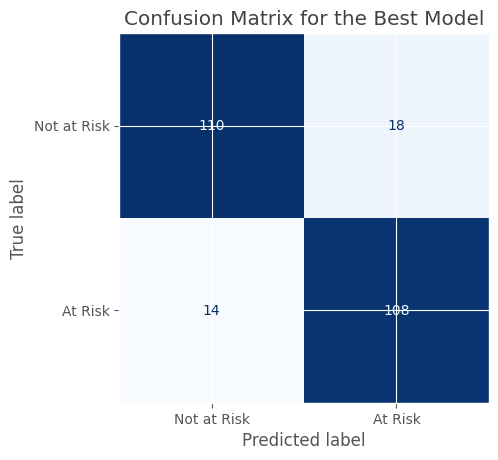

In [27]:
# Confusion Matrix.
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not at Risk', 'At Risk'])
disp.plot(cmap='Blues', colorbar=False) 
plt.title('Confusion Matrix for the Best Model', color=COLORS['black_complementary'])
plt.show()


AUC-ROC in the test set: 0.9501


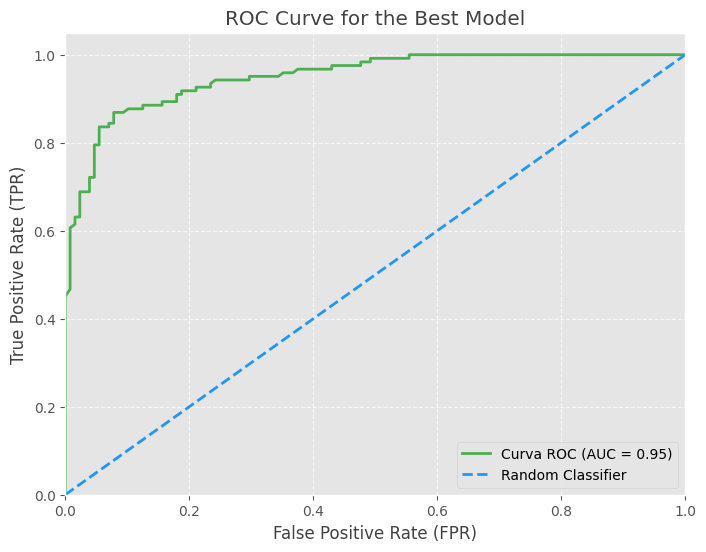

In [28]:
# ROC & AUC-ROC Curve.
roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

print(f"\nAUC-ROC in the test set: {roc_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color=COLORS['light_main'], lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color=COLORS['blue_complementary'], lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', color=COLORS['black_complementary'])
plt.ylabel('True Positive Rate (TPR)', color=COLORS['black_complementary'])
plt.title('ROC Curve for the Best Model', color=COLORS['black_complementary'])
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

AUC-PR in the test set: 0.9529


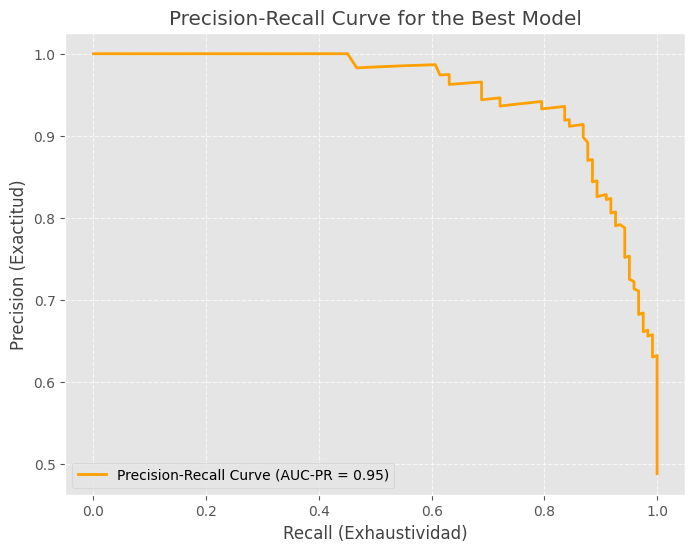

In [29]:
# Precision-Recall and AUC-PR curve.
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
auc_pr = auc(recall, precision)

print(f"AUC-PR in the test set: {auc_pr:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color=COLORS['dark_secundary'], lw=2, label=f'Precision-Recall Curve (AUC-PR = {auc_pr:.2f})')
plt.xlabel('Recall (Exhaustividad)', color=COLORS['black_complementary'])
plt.ylabel('Precision (Exactitud)', color=COLORS['black_complementary'])
plt.title('Precision-Recall Curve for the Best Model', color=COLORS['black_complementary'])
plt.legend(loc="lower left")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## Interpretation & Deployment of Insights


--- Interpretation & Deployment of Insights ---

Importance of Features (Top 10):
                  Feature  Importance
1     study_hours_per_day    0.395038
7    mental_health_rating    0.109203
2      social_media_hours    0.073475
4   attendance_percentage    0.071000
3           netflix_hours    0.070754
5             sleep_hours    0.067966
6      exercise_frequency    0.046082
0                     age    0.036974
19           diet_quality    0.020737
20       internet_quality    0.018040


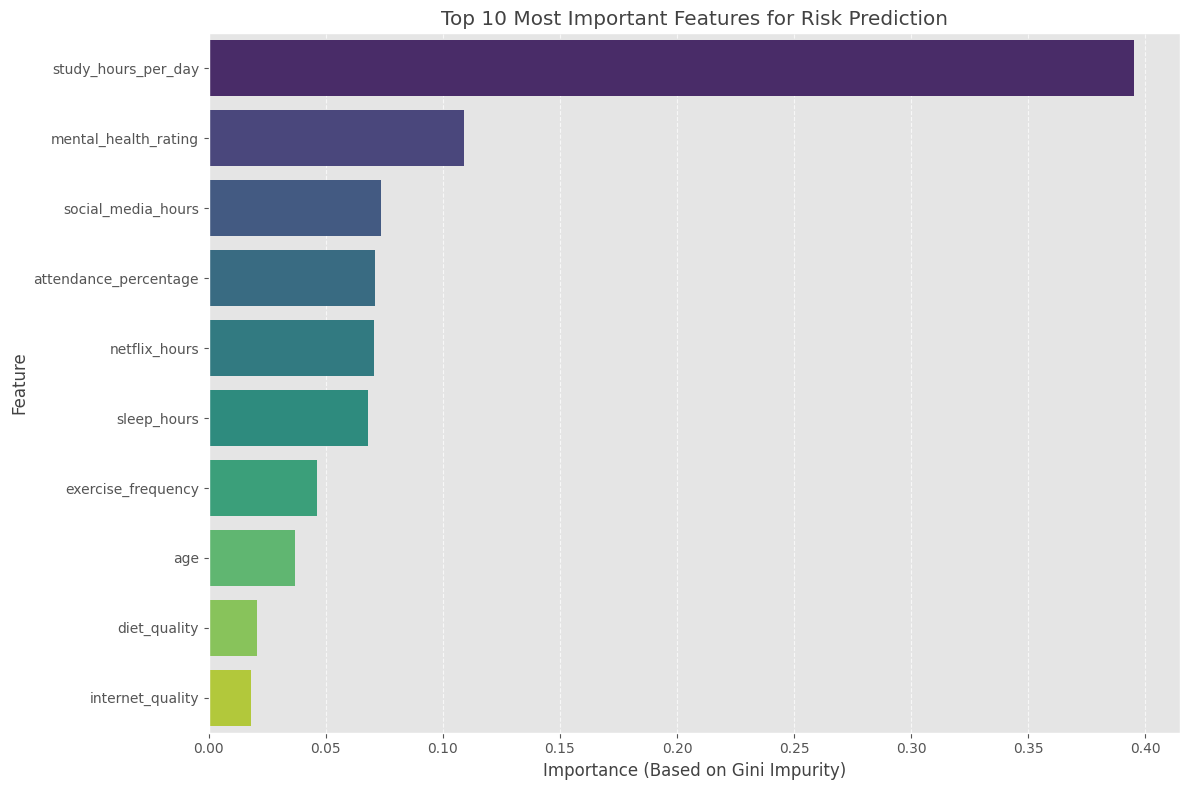

In [30]:
# --- Interpretation & Deployment of Insights ---
print("\n--- Interpretation & Deployment of Insights ---")

# Obtain the importance of the features of the best model.
# The classifier is a RandomForestClassifier, so it has the feature_importances_ attribute.
# First, we need the feature names after preprocessing.
feature_names_processed = []
feature_names_processed.extend(numerical_cols) # Numeric columns keep their names

# Names for columns encoded with OneHotEncoder

try:
    onehot_feature_names = best_model.named_steps['preprocessor'].named_transformers_['onehot'].get_feature_names_out(onehot_cols)
except AttributeError:
    onehot_feature_names = best_model.named_steps['preprocessor'].named_transformers_['onehot'].get_feature_names(onehot_cols)

feature_names_processed.extend(onehot_feature_names)

# Names for the coded ordinal columns
feature_names_processed.extend(ordinal_cols) # Ordinal columns keep their names

# Ensure that the length of feature_importances_ matches that of feature_names_processed
if len(feature_names_processed) != len(best_model.named_steps['classifier'].feature_importances_):
    print("Warning: The number of feature names does not match the importance of the features.")
    print("Feature importance without detailed names will be used if they do not match perfectly.")
    # Fallback if names do not match perfectly
    feature_importances_df = pd.DataFrame({
        'Feature': [f'Feature_{i}' for i in range(len(best_model.named_steps['classifier'].feature_importances_))],
        'Importance': best_model.named_steps['classifier'].feature_importances_
    })
else:
    feature_importances_df = pd.DataFrame({
        'Feature': feature_names_processed,
        'Importance': best_model.named_steps['classifier'].feature_importances_
    })

feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

print("\nImportance of Features (Top 10):")
print(feature_importances_df.head(10))

# Visualizing the importance of features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df.head(10), hue='Feature', palette='viridis')
plt.title('Top 10 Most Important Features for Risk Prediction', color=COLORS['black_complementary'])
plt.xlabel('Importance (Based on Gini Impurity)', color=COLORS['black_complementary'])
plt.ylabel('Feature', color=COLORS['black_complementary'])
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout() # Automatically adjusts shape parameters for a tight design.
plt.show()



In [31]:
# Actionable Conclusions and Recommendations based on Insights.
print("\n--- Conclusions and Actionable Recommendations ---")
print("Based on the evaluation of the model and the importance of the features:")

print("\n**Key Drivers of Underperformance Risk:**")
print("The factors that the model identifies as most influential in the risk of underperformance are (ordered by importance, according to the graph above):")
for index, row in feature_importances_df.head(5).iterrows(): # Shows the top 5 drivers of importance
    # Format the name for OneHotEncoder
    clean_feature_name = row['Feature'].replace('parental_education_level_Unknown', 'Parental Education Level (Unknown))')
    clean_feature_name = clean_feature_name.replace('gender_Other', 'Gender (Other)')
    clean_feature_name = clean_feature_name.replace('part_time_job_1.0', 'Has Part-Time Job')
    clean_feature_name = clean_feature_name.replace('extracurricular_participation_1.0', 'Participate in extracurricular activities')
    print(f"- {clean_feature_name}: Contribución de {row['Importance']:.4f}")


print("\nIn general, the most recurrent and logical insights for the risk of underperformance include:")
print("1.  **Study Time and Attendance:** Insufficient study time and poor class attendance are consistently the strongest predictors of academic problems. This highlights the need for direct engagement with study material and class participation.")
print("2.  **Excessive Digital Media Use:** A high number of hours spent on social media and streaming platforms is often associated with lower performance, likely due to distraction and displacement from study time.")
print("3.  **General Well-being:** Sleep quality and mental health are essential. Poor sleep or mental health issues can affect concentration, motivation, and learning ability.")
print("4.  **Socio-Contextual Factors:** Aspects such as parents' educational level may be influential, perhaps indicating differences in academic support or access to resources at home.")
print("5.  **Extracurricular Participation:** While it may seem counterintuitive, participation in extracurricular activities can be a two-pronged effort: too much can take away from studying, but balanced participation can improve well-being and soft skills.")

print("\n**Concrete Recommendations for Proactive Interventions:**")
print("To mitigate the risk of underperformance, the following actions are proposed based on model insights:")
print("1.  **Academic Reinforcement and Tutoring Programs:** For students with low study hours and/or poor attendance, offer personalized tutoring and supervised study programs.")
print("2.  **Time Management and Digital Literacy Workshops:** Raise awareness about the balanced use of technology and teach time management strategies to optimize study time.")
print("3.  **Psychological Support and Wellness Promotion Services:** Strengthen access to psychological counseling and therapy. Conduct campaigns on the importance of sleep and offer resources to improve rest habits.")
print("4.  **Family Inclusion and Support Initiatives:** For students with profiles that suggest lower family support (e.g., those with 'Parental Education Level (Unknown)' or lower educational levels if relevant), establish mentoring programs and provide additional resources that engage the family.")
print("5.  **Promoting a Healthy Lifestyle:** Although indirect, the quality of one's diet and frequency of exercise contribute to overall well-being. Promote healthy choices on campus and access to physical activities.")

print("\n**Considerations for Implementing the Early Warning System:**")
print("- **Continuous Integration:** The trained model can be integrated into existing student information systems to generate risk predictions on a regular basis (e.g., weekly or monthly).")
print("- **Monitoring Dashboard:** Develop an interactive dashboard (using BI tools or frameworks like Dash/Streamlit) so that counselors and educators can easily visualize at-risk students and their contributing factors.")
print("- **Custom Alerts:** Generate automatic alerts or reports directed to student support teams, allowing them to intervene proactively and in a personalized manner.")
print("- **Monitoring and Retraining:** Establish a process to continuously monitor model performance in production and periodically retrain it with new data to maintain its accuracy and relevance.")
print("- **Intervention Evaluation:** Collect data on the effectiveness of the interventions applied to refine strategies and validate the real impact of the system.")



--- Conclusions and Actionable Recommendations ---
Based on the evaluation of the model and the importance of the features:

**Key Drivers of Underperformance Risk:**
The factors that the model identifies as most influential in the risk of underperformance are (ordered by importance, according to the graph above):
- study_hours_per_day: Contribución de 0.3950
- mental_health_rating: Contribución de 0.1092
- social_media_hours: Contribución de 0.0735
- attendance_percentage: Contribución de 0.0710
- netflix_hours: Contribución de 0.0708

In general, the most recurrent and logical insights for the risk of underperformance include:
1.  **Study Time and Attendance:** Insufficient study time and poor class attendance are consistently the strongest predictors of academic problems. This highlights the need for direct engagement with study material and class participation.
2.  **Excessive Digital Media Use:** A high number of hours spent on social media and streaming platforms is often associ

In [32]:
# --- Save the predictive model ---
print("\n--- Saving the Model and Dataset with Predictions ---")

# File name to save the model
model_filename = 'student_performance_prediction_pipeline.pkl'

# Save the trained model
# This includes the preprocessor, SMOTE, and the classifier, all in one file.
joblib.dump(best_model, model_filename)
print(f"Model (full pipeline) saved as '{model_filename}'")


# Make predictions on the original (full) DataFrame
# We use the DataFrame 'df' which already has the real 'low_performance' column.
df_with_predictions = df.copy() # Copy the original DataFrame
df_with_predictions['predicted_low_performance'] = best_model.predict(df[features])

# Save the dataset with prediction labels
predictions_filename = 'students_with_performance_predictions.csv'
df_with_predictions.to_csv(predictions_filename, index=False)
print(f"Dataset with predictions saved as '{predictions_filename}'")

print("\n--- Project Completed ---")


--- Saving the Model and Dataset with Predictions ---
Model (full pipeline) saved as 'student_performance_prediction_pipeline.pkl'
Dataset with predictions saved as 'students_with_performance_predictions.csv'

--- Project Completed ---
